## Trend and Reversal Detection

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
import yfinance as yfin
ticker = '^GSPC'
start = pd.to_datetime('2007-01-01')
end = pd.to_datetime('2024-01-10')
SP500_ohlcv = yfin.download(ticker, start, end, progress=False)
SP500_close = SP500_ohlcv.loc[:,'Close']
SP500_close.head()

Date
2007-01-03    1416.599976
2007-01-04    1418.339966
2007-01-05    1409.709961
2007-01-08    1412.839966
2007-01-09    1412.109985
Name: Close, dtype: float64

In [3]:
SP500_close['2020-8-27':'2024-01-09']

Date
2020-08-27    3484.550049
2020-08-28    3508.010010
2020-08-31    3500.310059
2020-09-01    3526.649902
2020-09-02    3580.840088
                 ...     
2024-01-03    4704.810059
2024-01-04    4688.680176
2024-01-05    4697.240234
2024-01-08    4763.540039
2024-01-09    4756.500000
Name: Close, Length: 847, dtype: float64

In [4]:
(SP500_close['2024-01-09'] - SP500_close['2020-08-27']) / SP500_close['2020-08-27']

0.36502559393561856

In [5]:
def reversal_detection(input_data,threshold):
    """detect potential event and confirm reversal"""
    # initialize the original value
    N = len(input_data)
    df_result = pd.DataFrame(input_data)
    df_result.loc[:,'event'] = 0
    df_result.loc[:,'DC'] = 0
    df_result.loc[:,'trend'] = 0

    going_up = False
    P_high = input_data.iloc[0]
    P_low = input_data.iloc[0]
    event = 0

    for i in range(1,N):
        P_t = input_data.iloc[i]
        if going_up:  # 如果历史趋势是上涨
            if P_t <= P_high*(1-threshold):  # 如果出现明显下降，说明出现拐点
                going_up = False
                P_low = P_t
                #
                event = event + 1
            else:  # 未出现明显下降，说明仍是上涨趋势
                if P_high < P_t:
                    P_high = P_t
                    #
        else:  # 如果历史趋势是下降
            if P_t >= P_low*(1+threshold):  # 如果出现明显上涨，说明出现拐点
                going_up = True
                P_high = P_t
                #
                event = event + 1
            else:  # 未出现明显上涨，说明仍是下降趋势
                if P_low > P_t:
                    P_low = P_t
                    #
        df_result.iloc[i,df_result.columns.get_loc('event')] = event
    

    df_result = df_result.groupby(['event'],group_keys=False).apply(get_DC)
    df_result.loc[:,'trend'] = df_result.apply(get_trend,axis=1)

    return df_result


In [6]:
def get_DC(df):
    if df.iloc[0,df.columns.get_loc('event')] % 2 == 1:  # 奇数为up event
        df.loc[df['Close'].idxmax():,'DC'] = 1
    else:  # 偶数为down event
        df.loc[df['Close'].idxmin():,'DC'] = 1
    return df

In [7]:
def get_trend(df):
    if (df['event']%2 == 0): # down event
        if df['DC'] ==0: 
            ans = -1
        else:
            ans = 1
    else:  # up event
        if df['DC'] ==0: 
            ans = 1
        else:
            ans = -1
    return ans

In [8]:
df_result = reversal_detection(input_data=SP500_close,threshold=0.045)
df_result  # trend为1是是上涨区间，trend为-1是下降区间

,Close,event,DC,trend
Date,,,,
2007-01-03,1416.599976,0,0,-1
2007-01-04,1418.339966,0,0,-1
2007-01-05,1409.709961,0,0,-1
2007-01-08,1412.839966,0,0,-1
2007-01-09,1412.109985,0,0,-1
...,...,...,...,...
2024-01-03,4704.810059,155,1,-1
2024-01-04,4688.680176,155,1,-1
2024-01-05,4697.240234,155,1,-1


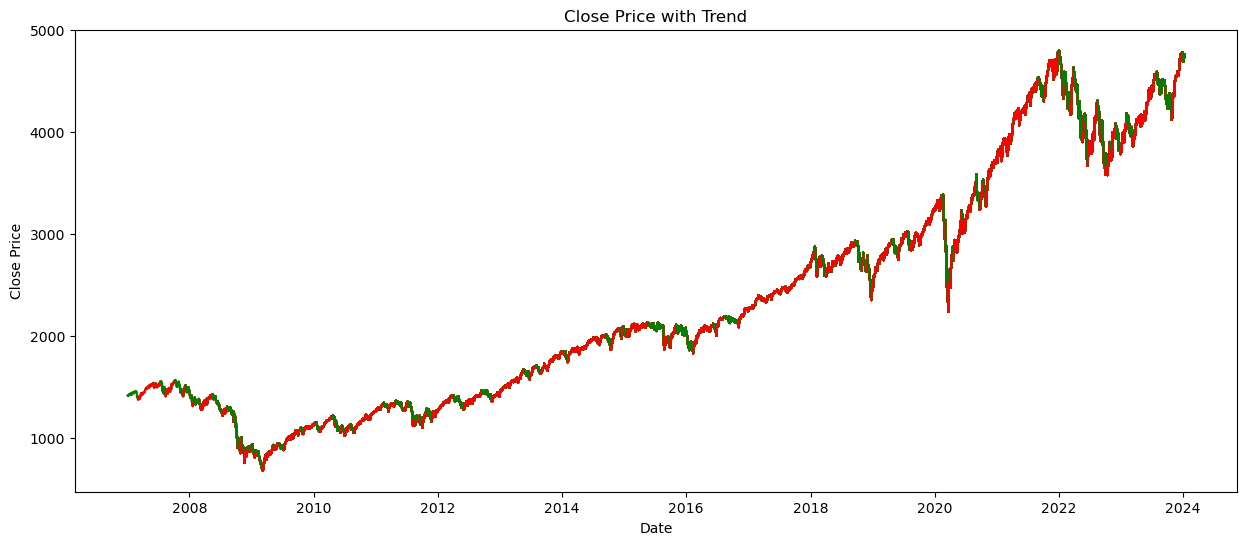

In [9]:
# 创建一个新的figure
plt.figure(figsize=(15, 6))

# 初始化变量以跟踪颜色切换点
previous_trend = df_result['trend'].iloc[0]
color = 'red' if previous_trend == 1 else 'green'

# 循环遍历数据点，绘制线段
start_index = df_result.index[0]
for date, row in df_result.iterrows():
    if row['trend'] != previous_trend:
        plt.plot(df_result.index[df_result.index >= start_index], df_result['Close'][df_result.index >= start_index], color=color)
        start_index = date
        color = 'red' if row['trend'] == 1 else 'green'
        previous_trend = row['trend']

# 绘制最后一个线段
plt.plot(df_result.index[df_result.index >= start_index], df_result['Close'][df_result.index >= start_index], color=color)

# 设置标题和轴标签
plt.title('Close Price with Trend')
plt.xlabel('Date')
plt.ylabel('Close Price')

# 显示图形
plt.show()

## Predict the length of OS after DC

In [10]:
df_result

,Close,event,DC,trend
Date,,,,
2007-01-03,1416.599976,0,0,-1
2007-01-04,1418.339966,0,0,-1
2007-01-05,1409.709961,0,0,-1
2007-01-08,1412.839966,0,0,-1
2007-01-09,1412.109985,0,0,-1
...,...,...,...,...
2024-01-03,4704.810059,155,1,-1
2024-01-04,4688.680176,155,1,-1
2024-01-05,4697.240234,155,1,-1


In [11]:
df_result['event_start'] = df_result.groupby('event')['event'].transform(lambda x: x.index[0])
df_result['event_end'] = df_result.groupby('event')['event'].transform(lambda x: x.index[-1])

# 步骤 1: 创建新列 DC_point 并初始化为 0
df_result['DC_point'] = 0

# 步骤 2 & 3: 对每个 event 分组，然后更新 DC_point
for event, group in df_result.groupby('event'):
    # 找到 DC 列中第一个值为 1 的行的索引
    first_dc_one_index = group[group['DC'] == 1].index.min()
    if pd.notna(first_dc_one_index):  # 确保找到了满足条件的行
        df_result.at[first_dc_one_index, 'DC_point'] = 1

df_result

,Close,event,DC,trend,event_start,event_end,DC_point
Date,,,,,,,
2007-01-03,1416.599976,0,0,-1,2007-01-03,2007-03-22,0
2007-01-04,1418.339966,0,0,-1,2007-01-03,2007-03-22,0
2007-01-05,1409.709961,0,0,-1,2007-01-03,2007-03-22,0
2007-01-08,1412.839966,0,0,-1,2007-01-03,2007-03-22,0
2007-01-09,1412.109985,0,0,-1,2007-01-03,2007-03-22,0
...,...,...,...,...,...,...,...
2024-01-03,4704.810059,155,1,-1,2023-11-02,2024-01-09,0
2024-01-04,4688.680176,155,1,-1,2023-11-02,2024-01-09,0
2024-01-05,4697.240234,155,1,-1,2023-11-02,2024-01-09,0


In [12]:
event_result = df_result.loc[df_result.loc[:,'DC_point']==1,:].copy()
event_result.loc[:,'DC_date'] = event_result.index
event_result.loc[:,'OS_len'] = event_result.loc[:,'DC_date'] - event_result.loc[:,'event_start']
event_result.loc[:,'DC_len'] = event_result.loc[:,'event_end'] - event_result.loc[:,'DC_date']
event_result

,Close,event,DC,trend,event_start,event_end,DC_point,DC_date,OS_len,DC_len
Date,,,,,,,,,,
2007-03-05,1374.119995,0,1,1,2007-01-03,2007-03-22,1,2007-03-05,61 days,17 days
2007-07-19,1553.079956,1,1,-1,2007-03-23,2007-07-25,1,2007-07-19,118 days,6 days
2007-08-15,1406.699951,2,1,1,2007-07-26,2007-08-23,1,2007-08-15,20 days,8 days
2007-10-09,1565.150024,3,1,-1,2007-08-24,2007-11-06,1,2007-10-09,46 days,28 days
2007-11-26,1407.219971,4,1,1,2007-11-07,2007-11-29,1,2007-11-26,19 days,3 days
...,...,...,...,...,...,...,...,...,...,...
2023-02-02,4179.759766,151,1,-1,2023-01-11,2023-02-21,1,2023-02-02,22 days,19 days
2023-03-13,3855.760010,152,1,1,2023-02-22,2023-03-29,1,2023-03-13,19 days,16 days
2023-07-31,4588.959961,153,1,-1,2023-03-30,2023-08-16,1,2023-07-31,123 days,16 days


In [13]:
# 预测目标：站在DC_end和OS_start的当天，利用历史数据预测未来OS可以持续多少天(即OS_len)

# target: 未来OS可以持续多少天(即OS_len)

# features: 
# event是顺序编号，无实意，与测试应当删除
# trend表示价格移动方向，1为上涨，0为下降
# DC_len表示确认reversal后，起点到现在的时间长度，根据论文应该是重要的解释变量
# DC_start, DC_end, OS_start, OS_end均是时间发生的事件。其中OS_end仅事后可知，DC_start, DC_end, OS_start不能作为直接的features，可选取当天的市场数据或六个月前当天的市场数据作为features

reversal_result = event_result.copy()
reversal_result.loc[:,'OS_len'] = reversal_result.loc[:,'OS_len'].shift(-1)
reversal_result.loc[:,'DC_start'] = reversal_result.loc[:,'DC_date']
reversal_result.loc[:,'DC_end'] = reversal_result.loc[:,'event_end']
reversal_result.loc[:,'OS_start'] = reversal_result.loc[:,'event_end']
reversal_result.loc[:,'OS_end'] = reversal_result.loc[:,'DC_date'].shift(-1)
reversal_result.loc[:,'event_len_lag'] = (reversal_result.loc[:,'DC_len']+reversal_result.loc[:,'OS_len']).shift(1)
reversal_result.loc[:,'trend'] = reversal_result['trend'].replace(-1, 0)
reversal_result = reversal_result.loc[:,['event','trend','DC_start','DC_end','OS_start','OS_end','event_len_lag','DC_len','OS_len']].dropna()
reversal_result

C:\Users\ldw\AppData\Local\Temp\ipykernel_27808\3936508132.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  reversal_result.loc[:,'OS_len'] = reversal_result.loc[:,'OS_len'].shift(-1)


,event,trend,DC_start,DC_end,OS_start,OS_end,event_len_lag,DC_len,OS_len
Date,,,,,,,,,
2007-07-19,1,0,2007-07-19,2007-07-25,2007-07-25,2007-08-15,135 days,6 days,20 days
2007-08-15,2,1,2007-08-15,2007-08-23,2007-08-23,2007-10-09,26 days,8 days,46 days
2007-10-09,3,0,2007-10-09,2007-11-06,2007-11-06,2007-11-26,54 days,28 days,19 days
2007-11-26,4,1,2007-11-26,2007-11-29,2007-11-29,2007-12-10,47 days,3 days,10 days
2007-12-10,5,0,2007-12-10,2007-12-14,2007-12-14,2008-01-22,13 days,4 days,36 days
...,...,...,...,...,...,...,...,...,...
2022-12-28,150,1,2022-12-28,2023-01-10,2023-01-10,2023-02-02,27 days,13 days,22 days
2023-02-02,151,0,2023-02-02,2023-02-21,2023-02-21,2023-03-13,35 days,19 days,19 days
2023-03-13,152,1,2023-03-13,2023-03-29,2023-03-29,2023-07-31,38 days,16 days,123 days


### linear regression without feature engineering

In [14]:
import statsmodels.api as sm

reversal_result['DC_len_days'] = reversal_result['DC_len'].dt.days
reversal_result['inter'] = reversal_result['DC_len_days'] * reversal_result['trend']

reversal_result['event_len_lag_days'] = reversal_result['event_len_lag'].dt.days
reversal_result['inter2'] = reversal_result['event_len_lag_days'] * reversal_result['trend']

reversal_result['OS_len_days'] = reversal_result['OS_len'].dt.days

X_train = reversal_result.loc[:,['trend','DC_len_days','inter','event_len_lag_days','inter2']]
y_train = reversal_result.loc[:,'OS_len_days']
model = sm.OLS(y_train, sm.add_constant(X_train))
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            OS_len_days   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     12.27
Date:                Mon, 26 Feb 2024   Prob (F-statistic):           5.88e-10
Time:                        22:09:40   Log-Likelihood:                -811.88
No. Observations:                 154   AIC:                             1636.
Df Residuals:                     148   BIC:                             1654.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  8.9159      7.435      1.199      0.232      -5.777      23.608
trend                 -8.3195     11.865     -0.701      0.484     -31.766      15.127
DC_len_days            0.0828      0.364      0.227      0.820      -0.637       0.802
inter                  4.0136      1.044      3.843      0.000       1.950       6.077
event_len_lag_days     0.0012      0.075      0.016      0.988      -0.147       0.150
inter2                 0.9535      0.269      3.546      0.001       0.422       1.485
==============================================================================
Omnibus:                      150.522   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2776.448
Skew:                           3.562   Prob(JB):                         0.00
Kurtosis:                      22.543   Cond. No.                         236.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### prepare MPD data

6 month MPD

In [15]:
mpd_6 = pd.read_excel('sp6m.xlsx', parse_dates=['idt'])
mpd_6.rename(columns={'idt':'date'}, inplace=True)
mpd_6.drop(['market','maturity_target'], axis=1, inplace=True)
mpd_6['date_6m'] = mpd_6['date'] + pd.DateOffset(months=6)
mpd_6.set_index('date',inplace=True)
mpd_6

,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,prInc,date_6m
date,,,,,,,,,,,,
2007-01-12,0.018803,0.086435,-1.079705,1.837194,-0.095498,0.03382,0.111149,-20,0.024242,20,0.001915,2007-07-12
2007-01-31,0.018350,0.077969,-1.046439,1.842209,-0.083769,0.03099,0.102377,-20,0.016758,20,0.000767,2007-07-31
2007-02-15,0.019976,0.084543,-1.001081,1.588657,-0.092096,0.03361,0.111834,-20,0.021096,20,0.001900,2007-08-15
2007-02-28,0.018823,0.100147,-1.031801,1.638698,-0.114332,0.03565,0.126683,-20,0.036788,20,0.007350,2007-08-28
2007-03-15,0.018767,0.099519,-1.058040,1.823271,-0.112902,0.03536,0.125505,-20,0.036138,20,0.007715,2007-09-15
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13,0.022320,0.097290,-1.198500,2.704270,-0.100300,0.03776,0.125810,-20,0.032020,20,0.007590,2024-06-13
2023-12-20,0.021640,0.105770,-1.030920,2.302840,-0.110120,0.03546,0.138320,-20,0.036470,20,0.017900,2024-06-20
2023-12-27,0.021510,0.100210,-1.156640,2.667710,-0.103680,0.03616,0.129090,-20,0.034090,20,0.010800,2024-06-27


In [16]:
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
X6m_pca = pca.fit_transform(mpd_6[['sd','p10','p90','prDec','prInc']])
first_ratio = pca.explained_variance_ratio_[0]
print("Percentage of Variance Explained by the First Principal Component: {:.2%}".format(first_ratio))
mpd_6['pca'] = X6m_pca[:, 0]
mpd_6

Percentage of Variance Explained by the First Principal Component: 96.48%


,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,prInc,date_6m,pca
date,,,,,,,,,,,,,
2007-01-12,0.018803,0.086435,-1.079705,1.837194,-0.095498,0.03382,0.111149,-20,0.024242,20,0.001915,2007-07-12,-0.116536
2007-01-31,0.018350,0.077969,-1.046439,1.842209,-0.083769,0.03099,0.102377,-20,0.016758,20,0.000767,2007-07-31,-0.133775
2007-02-15,0.019976,0.084543,-1.001081,1.588657,-0.092096,0.03361,0.111834,-20,0.021096,20,0.001900,2007-08-15,-0.120335
2007-02-28,0.018823,0.100147,-1.031801,1.638698,-0.114332,0.03565,0.126683,-20,0.036788,20,0.007350,2007-08-28,-0.086555
2007-03-15,0.018767,0.099519,-1.058040,1.823271,-0.112902,0.03536,0.125505,-20,0.036138,20,0.007715,2007-09-15,-0.088224
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13,0.022320,0.097290,-1.198500,2.704270,-0.100300,0.03776,0.125810,-20,0.032020,20,0.007590,2024-06-13,-0.098346
2023-12-20,0.021640,0.105770,-1.030920,2.302840,-0.110120,0.03546,0.138320,-20,0.036470,20,0.017900,2024-06-20,-0.078202
2023-12-27,0.021510,0.100210,-1.156640,2.667710,-0.103680,0.03616,0.129090,-20,0.034090,20,0.010800,2024-06-27,-0.091733


12 month MPD

In [17]:
mpd_12 = pd.read_excel('sp12m.xlsx', parse_dates=['idt'])
mpd_12.rename(columns={'idt':'date'}, inplace=True)
mpd_12.drop(['market','maturity_target'], axis=1, inplace=True)
mpd_12['date_12m'] = mpd_12['date'] + pd.DateOffset(months=12)
mpd_12.set_index('date',inplace=True)
mpd_12

,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,prInc,date_12m
date,,,,,,,,,,,,
2007-01-12,0.034318,0.132616,-1.055814,1.657518,-0.142450,0.057748,0.176416,-20,0.061515,20,0.056906,2008-01-12
2007-01-31,0.034214,0.127646,-1.046950,1.586451,-0.138259,0.057101,0.170867,-20,0.057727,20,0.048627,2008-01-31
2007-02-15,0.033657,0.124386,-1.014142,1.566904,-0.132251,0.054341,0.168377,-20,0.053694,20,0.045371,2008-02-15
2007-02-28,0.031560,0.141960,-0.914294,1.341103,-0.155426,0.051933,0.189108,-20,0.070289,20,0.080665,2008-02-28
2007-03-15,0.032992,0.145163,-1.071623,1.637862,-0.162516,0.059630,0.187690,-20,0.075176,20,0.076074,2008-03-15
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13,0.036330,0.156010,-1.290760,2.901370,-0.161130,0.063430,0.198980,-20,0.076450,20,0.097780,2024-12-13
2023-12-20,0.034040,0.165240,-1.130510,2.343460,-0.176420,0.060680,0.211050,-20,0.084650,20,0.119310,2024-12-20
2023-12-27,0.034240,0.160350,-1.239480,2.770920,-0.168490,0.061270,0.202830,-20,0.080470,20,0.105120,2024-12-27


In [18]:
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
X12m_pca = pca.fit_transform(mpd_12[['sd','p10','p90','prDec','prInc']])
first_ratio = pca.explained_variance_ratio_[0]
print("Percentage of Variance Explained by the First Principal Component: {:.2%}".format(first_ratio))
mpd_12['pca'] = X12m_pca[:, 0]
mpd_12

Percentage of Variance Explained by the First Principal Component: 90.97%


,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,prInc,date_12m,pca
date,,,,,,,,,,,,,
2007-01-12,0.034318,0.132616,-1.055814,1.657518,-0.142450,0.057748,0.176416,-20,0.061515,20,0.056906,2008-01-12,-0.161894
2007-01-31,0.034214,0.127646,-1.046950,1.586451,-0.138259,0.057101,0.170867,-20,0.057727,20,0.048627,2008-01-31,-0.173530
2007-02-15,0.033657,0.124386,-1.014142,1.566904,-0.132251,0.054341,0.168377,-20,0.053694,20,0.045371,2008-02-15,-0.182316
2007-02-28,0.031560,0.141960,-0.914294,1.341103,-0.155426,0.051933,0.189108,-20,0.070289,20,0.080665,2008-02-28,-0.131672
2007-03-15,0.032992,0.145163,-1.071623,1.637862,-0.162516,0.059630,0.187690,-20,0.075176,20,0.076074,2008-03-15,-0.126963
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13,0.036330,0.156010,-1.290760,2.901370,-0.161130,0.063430,0.198980,-20,0.076450,20,0.097780,2024-12-13,-0.109141
2023-12-20,0.034040,0.165240,-1.130510,2.343460,-0.176420,0.060680,0.211050,-20,0.084650,20,0.119310,2024-12-20,-0.078941
2023-12-27,0.034240,0.160350,-1.239480,2.770920,-0.168490,0.061270,0.202830,-20,0.080470,20,0.105120,2024-12-27,-0.096718


merge MPD data with reversal data

In [19]:
basic_features = ['mu', 'skew', 'kurt', 'p50', 'pca']

In [20]:
reversal_6m = pd.merge_asof(reversal_result, mpd_6[basic_features], left_on='DC_end', right_index=True).dropna()
reversal_6m

,event,trend,DC_start,DC_end,OS_start,OS_end,event_len_lag,DC_len,OS_len,DC_len_days,inter,event_len_lag_days,inter2,OS_len_days,mu,skew,kurt,p50,pca
Date,,,,,,,,,,,,,,,,,,,
2007-07-19,1,0,2007-07-19,2007-07-25,2007-07-25,2007-08-15,135 days,6 days,20 days,6,0,135,0,20,0.019513,-1.049040,1.609064,0.039265,-0.060851
2007-08-15,2,1,2007-08-15,2007-08-23,2007-08-23,2007-10-09,26 days,8 days,46 days,8,8,26,26,46,0.011459,-0.918484,1.225744,0.034003,0.070573
2007-10-09,3,0,2007-10-09,2007-11-06,2007-11-06,2007-11-26,54 days,28 days,19 days,28,0,54,0,19,0.015683,-1.193114,2.008658,0.043004,0.004487
2007-11-26,4,1,2007-11-26,2007-11-29,2007-11-29,2007-12-10,47 days,3 days,10 days,3,3,47,47,10,0.007859,-1.092337,1.596159,0.039182,0.102645
2007-12-10,5,0,2007-12-10,2007-12-14,2007-12-14,2008-01-22,13 days,4 days,36 days,4,0,13,0,36,0.005947,-0.892178,1.131814,0.029414,0.083295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-28,150,1,2022-12-28,2023-01-10,2023-01-10,2023-02-02,27 days,13 days,22 days,13,13,27,27,22,0.014280,-0.932230,1.486460,0.039050,0.064470
2023-02-02,151,0,2023-02-02,2023-02-21,2023-02-21,2023-03-13,35 days,19 days,19 days,19,0,35,0,19,0.018450,-1.227810,2.607090,0.041410,-0.016320
2023-03-13,152,1,2023-03-13,2023-03-29,2023-03-29,2023-07-31,38 days,16 days,123 days,16,16,38,38,123,0.018140,-1.183520,2.370690,0.042690,0.001794


In [21]:
reversal_12m = pd.merge_asof(reversal_result, mpd_12[basic_features], left_on='DC_end', right_index=True).dropna()
reversal_12m

,event,trend,DC_start,DC_end,OS_start,OS_end,event_len_lag,DC_len,OS_len,DC_len_days,inter,event_len_lag_days,inter2,OS_len_days,mu,skew,kurt,p50,pca
Date,,,,,,,,,,,,,,,,,,,
2007-07-19,1,0,2007-07-19,2007-07-25,2007-07-25,2007-08-15,135 days,6 days,20 days,6,0,135,0,20,0.034148,-1.037901,1.367139,0.064879,-0.072105
2007-08-15,2,1,2007-08-15,2007-08-23,2007-08-23,2007-10-09,26 days,8 days,46 days,8,8,26,26,46,0.026813,-0.973459,1.383069,0.059035,0.085265
2007-10-09,3,0,2007-10-09,2007-11-06,2007-11-06,2007-11-26,54 days,28 days,19 days,28,0,54,0,19,0.026925,-1.206264,2.195787,0.063555,0.041817
2007-11-26,4,1,2007-11-26,2007-11-29,2007-11-29,2007-12-10,47 days,3 days,10 days,3,3,47,47,10,0.005655,-0.948663,1.011719,0.047500,0.178580
2007-12-10,5,0,2007-12-10,2007-12-14,2007-12-14,2008-01-22,13 days,4 days,36 days,4,0,13,0,36,0.006523,-0.771469,0.640740,0.041292,0.132570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-28,150,1,2022-12-28,2023-01-10,2023-01-10,2023-02-02,27 days,13 days,22 days,13,13,27,27,22,0.023460,-1.062610,1.839560,0.063800,0.089093
2023-02-02,151,0,2023-02-02,2023-02-21,2023-02-21,2023-03-13,35 days,19 days,19 days,19,0,35,0,19,0.033690,-1.330810,2.821020,0.072160,-0.010508
2023-03-13,152,1,2023-03-13,2023-03-29,2023-03-29,2023-07-31,38 days,16 days,123 days,16,16,38,38,123,0.030300,-1.299480,2.695050,0.069560,0.010431


In [22]:
X_train = reversal_6m.loc[:,['trend','DC_len_days','inter']]
y_train = reversal_6m.loc[:,'OS_len_days']
model = sm.OLS(y_train, sm.add_constant(X_train))
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            OS_len_days   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     14.74
Date:                Mon, 26 Feb 2024   Prob (F-statistic):           1.84e-08
Time:                        22:09:40   Log-Likelihood:                -818.68
No. Observations:                 154   AIC:                             1645.
Df Residuals:                     150   BIC:                             1658.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           8.9581      7.186      1.247      0.214      -5.240      23.156
trend           8.5104     11.015      0.773      0.441     -13.255      30.275
DC_len_days     0.0845      0.360      0.234      0.815      -0.628       0.797
inter           4.7120      1.060      4.445      0.000       2.617       6.807
==============================================================================
Omnibus:                      169.940   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4437.903
Skew:                           4.139   Prob(JB):                         0.00
Kurtosis:                      27.962   Cond. No.                         47.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Forward Selection of Interaction Terms Based on BIC

In [23]:
def create_inter(data,columns):
    inter_columns = []
    for col_1 in columns:
        for col_2 in columns:
            data[f'{col_1}_x_{col_2}'] = data[col_1] * data[col_2]
            inter_columns.append(f'{col_1}_x_{col_2}')
    return data, inter_columns

In [24]:
def split_train_test(X, y, train_size):
    
    idx = int(np.floor(train_size * len(X)))
    
    test_start = idx
    end = len(X)
    
    X_train = X[:idx]
    X_test = X[idx:end]
    y_train = y[:idx]
    y_test = y[idx:end]
    
    return X_train, X_test, y_train, y_test

In [25]:
def forward_select_linear_bic(X, y):
    remaining = set(X.columns)
    selected = []
    current_score = float('inf')
    
    while remaining:
        scores_with_candidates = []
        for candidate in remaining:
            X_temp = pd.concat([X[selected],X[candidate]],axis=1)
            score = sm.OLS(y,sm.add_constant(X_temp.astype(float))).fit().aic
            scores_with_candidates.append((score, candidate))
        
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates[0]
        
        if current_score > best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
            print("bic is {},continuing!".format(current_score)) 
        else:
            print("for selection over!")
            break

    return selected

In [26]:
# Creat interaction terms
columns = ['mu','skew','kurt','p50','pca','trend','DC_len_days','event_len_lag_days']
reversal_6m, inter_columns_6m = create_inter(reversal_6m,columns)
reversal_6m

,event,trend,DC_start,DC_end,OS_start,OS_end,event_len_lag,DC_len,OS_len,DC_len_days,...,DC_len_days_x_DC_len_days,DC_len_days_x_event_len_lag_days,event_len_lag_days_x_mu,event_len_lag_days_x_skew,event_len_lag_days_x_kurt,event_len_lag_days_x_p50,event_len_lag_days_x_pca,event_len_lag_days_x_trend,event_len_lag_days_x_DC_len_days,event_len_lag_days_x_event_len_lag_days
Date,,,,,,,,,,,,,,,,,,,,,
2007-07-19,1,0,2007-07-19,2007-07-25,2007-07-25,2007-08-15,135 days,6 days,20 days,6,...,36,810,2.634288,-141.620420,217.223645,5.300763,-8.214869,0,810,18225
2007-08-15,2,1,2007-08-15,2007-08-23,2007-08-23,2007-10-09,26 days,8 days,46 days,8,...,64,208,0.297947,-23.880584,31.869354,0.884078,1.834901,26,208,676
2007-10-09,3,0,2007-10-09,2007-11-06,2007-11-06,2007-11-26,54 days,28 days,19 days,28,...,784,1512,0.846872,-64.428171,108.467505,2.322230,0.242297,0,1512,2916
2007-11-26,4,1,2007-11-26,2007-11-29,2007-11-29,2007-12-10,47 days,3 days,10 days,3,...,9,141,0.369387,-51.339853,75.019460,1.841555,4.824331,47,141,2209
2007-12-10,5,0,2007-12-10,2007-12-14,2007-12-14,2008-01-22,13 days,4 days,36 days,4,...,16,52,0.077308,-11.598316,14.713585,0.382385,1.082832,0,52,169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-28,150,1,2022-12-28,2023-01-10,2023-01-10,2023-02-02,27 days,13 days,22 days,13,...,169,351,0.385560,-25.170210,40.134420,1.054350,1.740681,27,351,729
2023-02-02,151,0,2023-02-02,2023-02-21,2023-02-21,2023-03-13,35 days,19 days,19 days,19,...,361,665,0.645750,-42.973350,91.248150,1.449350,-0.571186,0,665,1225
2023-03-13,152,1,2023-03-13,2023-03-29,2023-03-29,2023-07-31,38 days,16 days,123 days,16,...,256,608,0.689320,-44.973760,90.086220,1.622220,0.068155,38,608,1444


In [81]:
reversal_6m['2020']

C:\Users\ldw\AppData\Local\Temp\ipykernel_27808\4179757563.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  reversal_6m['2020']


,event,trend,DC_start,DC_end,OS_start,OS_end,event_len_lag,DC_len,OS_len,DC_len_days,...,DC_len_days_x_DC_len_days,DC_len_days_x_event_len_lag_days,event_len_lag_days_x_mu,event_len_lag_days_x_skew,event_len_lag_days_x_kurt,event_len_lag_days_x_p50,event_len_lag_days_x_pca,event_len_lag_days_x_trend,event_len_lag_days_x_DC_len_days,event_len_lag_days_x_event_len_lag_days
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-19,111,0,2020-02-19,2020-02-21,2020-02-21,2020-02-28,188 days,2 days,4 days,2,...,4,376,0.50948,-261.64712,561.64248,4.39544,-14.266087,0,376,35344
2020-02-28,112,1,2020-02-28,2020-02-28,2020-02-28,2020-03-04,6 days,0 days,2 days,0,...,0,0,-0.01260,-6.91764,10.68624,0.16242,0.088487,6,0,36
2020-03-04,113,0,2020-03-04,2020-03-05,2020-03-05,2020-03-09,2 days,1 days,3 days,1,...,1,2,-0.01094,-2.92098,4.97738,0.07524,0.129375,0,2,4
2020-03-09,114,1,2020-03-09,2020-03-09,2020-03-09,2020-03-10,4 days,0 days,0 days,0,...,0,0,-0.02188,-5.84196,9.95476,0.15048,0.258750,4,0,16
2020-03-10,115,0,2020-03-10,2020-03-10,2020-03-10,2020-03-12,0 days,0 days,1 days,0,...,0,0,-0.00000,-0.00000,0.00000,0.00000,0.000000,0,0,0
2020-03-12,116,1,2020-03-12,2020-03-12,2020-03-12,2020-03-13,1 days,0 days,0 days,0,...,0,0,-0.01912,-1.19383,1.38888,0.05340,0.330769,1,0,1
2020-03-13,117,0,2020-03-13,2020-03-13,2020-03-13,2020-03-16,0 days,0 days,0 days,0,...,0,0,-0.00000,-0.00000,0.00000,0.00000,0.000000,0,0,0
2020-03-16,118,1,2020-03-16,2020-03-16,2020-03-16,2020-03-17,0 days,0 days,0 days,0,...,0,0,-0.00000,-0.00000,0.00000,0.00000,0.000000,0,0,0
2020-03-17,119,0,2020-03-17,2020-03-17,2020-03-17,2020-03-23,0 days,0 days,5 days,0,...,0,0,-0.00000,-0.00000,0.00000,0.00000,0.000000,0,0,0


In [27]:
X = reversal_6m[inter_columns_6m]
y = reversal_6m['OS_len_days']
train_size = 0.8
X_train, X_test, y_train, y_test = split_train_test(X, y, train_size)
selected_columns_6m = forward_select_linear_bic(X_train, y_train)
selected_columns_6m

bic is 1301.9283219835263,continuing!
bic is 1288.8404050668562,continuing!
bic is 1288.162862863544,continuing!
bic is 1286.9524387621996,continuing!
for selection over!


['DC_len_days_x_trend',
 'event_len_lag_days_x_trend',
 'pca_x_trend',
 'mu_x_trend']

In [28]:
# Creat interaction terms
columns = ['mu','skew','kurt','p50','pca','trend','DC_len_days','event_len_lag_days']
reversal_12m, inter_columns_12m = create_inter(reversal_12m,columns)
X = reversal_12m[inter_columns_12m]
y = reversal_12m['OS_len_days']
train_size = 0.8
X_train, X_test, y_train, y_test = split_train_test(X, y, train_size)
selected_columns_12m = forward_select_linear_bic(X_train, y_train)
selected_columns_12m

bic is 1301.9283219835263,continuing!
bic is 1288.8404050668562,continuing!
bic is 1287.6247179394638,continuing!
bic is 1285.1661330638121,continuing!
for selection over!


['DC_len_days_x_trend',
 'event_len_lag_days_x_trend',
 'pca_x_trend',
 'mu_x_trend']

### Linear Regression od Reversal

In [29]:
X_train = reversal_6m.loc[:,['trend','DC_len_days','event_len_lag_days','DC_len_days_x_trend','event_len_lag_days_x_trend']]
y_train = reversal_6m.loc[:,'OS_len_days']
model = sm.OLS(y_train, sm.add_constant(X_train))
results1 = model.fit()

results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            OS_len_days   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     12.27
Date:                Mon, 26 Feb 2024   Prob (F-statistic):           5.88e-10
Time:                        22:09:42   Log-Likelihood:                -811.88
No. Observations:                 154   AIC:                             1636.
Df Residuals:                     148   BIC:                             1654.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          8.9159      7.435      1.199      0.232      -5.777      23.608
trend                         -8.3195     11.865     -0.701      0.484     -31.766      15.127
DC_len_days                    0.0828      0.364      0.227      0.820      -0.637       0.802
event_len_lag_days             0.0012      0.075      0.016      0.988      -0.147       0.150
DC_len_days_x_trend            4.0136      1.044      3.843      0.000       1.950       6.077
event_len_lag_days_x_trend     0.9535      0.269      3.546      0.001       0.422       1.485
==============================================================================
Omnibus:                      150.522   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2776.448
Skew:                           3.562   Prob(JB):                         0.00
Kurtosis:                      22.543   Cond. No.                         236.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
X_train = reversal_6m.loc[:,['trend','DC_len_days','event_len_lag_days']+selected_columns_6m+['mu','skew','kurt','p50','pca']]
y_train = reversal_6m.loc[:,'OS_len_days']
model = sm.OLS(y_train, sm.add_constant(X_train))
results2 = model.fit()

results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            OS_len_days   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     5.588
Date:                Mon, 26 Feb 2024   Prob (F-statistic):           8.86e-08
Time:                        22:09:42   Log-Likelihood:                -808.62
No. Observations:                 154   AIC:                             1643.
Df Residuals:                     141   BIC:                             1683.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -3.5582     49.064     -0.073      0.942    -100.554      93.437
trend                          6.7377     19.092      0.353      0.725     -31.007      44.482
DC_len_days                    0.0676      0.412      0.164      0.870      -0.747       0.883
event_len_lag_days            -0.0077      0.086     -0.089      0.929      -0.178       0.163
DC_len_days_x_trend            3.2757      1.171      2.798      0.006       0.962       5.590
event_len_lag_days_x_trend     0.8406      0.300      2.800      0.006       0.247       1.434
pca_x_trend                 -142.8625     90.653     -1.576      0.117    -322.078      36.353
mu_x_trend                 -1826.9145    985.213     -1.854      0.066   -3774.612     120.783
mu                           471.1576   1244.732      0.379      0.706   -1989.593    2931.908
skew                           0.2590     98.183      0.003      0.998    -193.843     194.361
kurt                           4.3764     23.847      0.184      0.855     -42.768      51.521
p50                          136.2165    906.789      0.150      0.881   -1656.444    1928.877
pca                           29.0604     98.130      0.296      0.768    -164.937     223.058
==============================================================================
Omnibus:                      147.340   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2640.648
Skew:                           3.457   Prob(JB):                         0.00
Kurtosis:                      22.072   Cond. No.                     2.71e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.71e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
summary1 = results1.summary()
summary2 = results2.summary()

coef_table1 = pd.DataFrame(summary1.tables[1].data)
coef_table1.columns = coef_table1.iloc[0]
coef_table1 = coef_table1.drop(coef_table1.index[0])

coef_table2 = pd.DataFrame(summary2.tables[1].data)
coef_table2.columns = coef_table2.iloc[0]
coef_table2 = coef_table2.drop(coef_table2.index[0])

with pd.ExcelWriter('reversal_prediction.xlsx') as writer:
    coef_table1.to_excel(writer, sheet_name='Model 1 Coefficients', index=False)
    coef_table2.to_excel(writer, sheet_name='Model 2 Coefficients', index=False)

print("两个模型的结果已经保存到 'reversal_prediction.xlsx' 的不同工作表中")

两个模型的结果已经保存到 'reversal_prediction.xlsx' 的不同工作表中


### Machine Learning Models for Reversal Prediction

without MPD

In [32]:
X = reversal_6m.loc[:,['trend','DC_len_days','event_len_lag_days','DC_len_days_x_trend']]
y = reversal_6m.loc[:,'OS_len_days']
train_size = 0.90
X_train, X_test, y_train, y_test = split_train_test(X, y, train_size)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(138, 4) (16, 4)
(138,) (16,)


In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

def model_training_and_evaluating(model, X_train, X_test, y_train, y_test,scaler=True):
    # Feature Scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = np.where(y_pred < 0, 0, y_pred)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'R2 Score: {r2}')
    # print(y_pred)

    return model, y_pred

In [34]:
#xgboost
from xgboost import XGBRegressor
model = XGBRegressor(booster='gblinear')
model, y_pred4 = model_training_and_evaluating(model, X_train, X_test, y_train, y_test, scaler=True)

Mean Squared Error: 840.0723343691434
Mean Absolute Error: 20.978869438171387
R2 Score: 0.21137323946277697


In [35]:
X = reversal_6m.loc[:,['trend','DC_len_days','event_len_lag_days']]
y = reversal_6m.loc[:,'OS_len_days']
train_size = 0.90
X_train, X_test, y_train, y_test = split_train_test(X, y, train_size)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(138, 3) (16, 3)
(138,) (16,)


In [36]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model, y_pred1 = model_training_and_evaluating(model, X_train, X_test, y_train, y_test,scaler=True)

Mean Squared Error: 996.3437060160346
Mean Absolute Error: 22.595424733479227
R2 Score: 0.06467184180379593


In [37]:
from sklearn.svm import SVR
model = SVR(kernel='rbf',C=10,epsilon=29)
model, y_pred2 = model_training_and_evaluating(model, X_train, X_test, y_train, y_test,scaler=True)

Mean Squared Error: 837.2744809134854
Mean Absolute Error: 24.89079680334202
R2 Score: 0.21399975389126413


6-month MPD

In [38]:
X = reversal_6m.loc[:,['trend','DC_len_days','event_len_lag_days']+selected_columns_6m+['mu','skew','kurt','p50','pca']]
y = reversal_6m.loc[:,'OS_len_days']
train_size = 0.90
X_train, X_test, y_train, y_test = split_train_test(X, y, train_size)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(138, 12) (16, 12)
(138,) (16,)


In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

def model_training_and_evaluating(model, X_train, X_test, y_train, y_test,scaler=True):
    # Feature Scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = np.where(y_pred < 0, 0, y_pred)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'R2 Score: {r2}')
    # print(y_pred)

    return model, y_pred

In [40]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model, y_pred1 = model_training_and_evaluating(model, X_train, X_test, y_train, y_test,scaler=True)

Mean Squared Error: 562.3774712878346
Mean Absolute Error: 19.37837747060617
R2 Score: 0.47206221983980323


In [41]:
from sklearn.svm import SVR
model = SVR(kernel='rbf',C=100,epsilon=20)
model, y_pred2 = model_training_and_evaluating(model, X_train, X_test, y_train, y_test,scaler=True)

Mean Squared Error: 718.1242409190689
Mean Absolute Error: 20.67591520168683
R2 Score: 0.3258532978537526


In [42]:
model = RandomForestRegressor(n_estimators=30,max_depth=15,random_state=8)
model, y_pred3 = model_training_and_evaluating(model, X_train, X_test, y_train, y_test, scaler=True)

Mean Squared Error: 3990.3741274777094
Mean Absolute Error: 38.82460648148148
R2 Score: -2.7460057815705667


In [43]:
#xgboost
from xgboost import XGBRegressor
model = XGBRegressor(eval_metric='rmse',booster='gblinear')
model, y_pred4 = model_training_and_evaluating(model, X_train, X_test, y_train, y_test, scaler=True)

Mean Squared Error: 568.083228814533
Mean Absolute Error: 18.67405104637146
R2 Score: 0.46670587980740585


12-month MPD

In [44]:
X = reversal_12m.loc[:,['trend','DC_len_days','event_len_lag_days']+selected_columns_12m+['mu','skew','kurt','p50','pca']]
y = reversal_12m.loc[:,'OS_len_days']
train_size = 0.90
X_train, X_test, y_train, y_test = split_train_test(X, y, train_size)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(138, 12) (16, 12)
(138,) (16,)


In [45]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model, y_pred1 = model_training_and_evaluating(model, X_train, X_test, y_train, y_test,scaler=True)

Mean Squared Error: 597.337815307843
Mean Absolute Error: 19.27091569922643
R2 Score: 0.4392428283138694


In [46]:
from sklearn.svm import SVR
model = SVR(kernel='rbf',C=100,epsilon=17)
model, y_pred2 = model_training_and_evaluating(model, X_train, X_test, y_train, y_test,scaler=True)

Mean Squared Error: 737.0659512499722
Mean Absolute Error: 21.912734411676038
R2 Score: 0.3080715675834511


In [47]:
model = RandomForestRegressor(n_estimators=30,max_depth=15,random_state=42)
model, y_pred3 = model_training_and_evaluating(model, X_train, X_test, y_train, y_test, scaler=True)

Mean Squared Error: 3821.113697916666
Mean Absolute Error: 46.01145833333333
R2 Score: -2.5871107688546626


In [48]:
#xgboost
from xgboost import XGBRegressor
model = XGBRegressor(eval_metric='rmse',booster='gblinear')
model, y_pred4 = model_training_and_evaluating(model, X_train, X_test, y_train, y_test, scaler=True)

Mean Squared Error: 591.5575077038077
Mean Absolute Error: 18.495432034134865
R2 Score: 0.44466915301732757


### Ensembled Models

In [49]:
X = reversal_6m[columns+selected_columns_6m+['inter']]
y = reversal_6m['OS_len_days']

X_train = X.loc['2007':'2020-06',:]
y_train = y.loc['2007':'2020-06']

X_test = X.loc['2020-07':,:]
y_test = y.loc['2020-07':]

In [50]:
columns

['mu',
 'skew',
 'kurt',
 'p50',
 'pca',
 'trend',
 'DC_len_days',
 'event_len_lag_days']

In [51]:
selected_columns_6m

['DC_len_days_x_trend',
 'event_len_lag_days_x_trend',
 'pca_x_trend',
 'mu_x_trend']

In [52]:
# X = reversal_6m[columns+selected_columns_6m+['inter']]
# y = reversal_6m['OS_len_days']
# train_size = 0.90
# X_train, X_test, y_train, y_test = split_train_test(X, y, train_size)

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

def model_training_and_evaluating(model, X_train, X_test, y_train, y_test,scaler=True):
    # Feature Scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = np.where(y_pred < 0, 0, y_pred)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'R2 Score: {r2}')
    # print(y_pred)

    return model, y_pred

In [54]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model, y_pred1 = model_training_and_evaluating(model, X_train, X_test, y_train, y_test,scaler=True)

Mean Squared Error: 3483.3764839435944
Mean Absolute Error: 31.515523005840617
R2 Score: 0.0026629462692249195


In [55]:
from sklearn.svm import SVR
model = SVR(kernel='rbf',C=100,epsilon=30)
model, y_pred2 = model_training_and_evaluating(model, X_train, X_test, y_train, y_test,scaler=True)

Mean Squared Error: 3314.242768518167
Mean Absolute Error: 32.1407962828912
R2 Score: 0.05108818029330209


In [56]:
# X = reversal_6m[columns+inter_columns_6m]
# # X = reversal_6m[columns+selected_columns_6m+['inter']]
# y = reversal_6m['OS_len_days']

# X_train = X.loc['2007':'2020-06',:]
# y_train = y.loc['2007':'2020-06']

# X_test = X.loc['2020-07':,:]
# y_test = y.loc['2020-07':]

In [57]:
model = RandomForestRegressor(n_estimators=5,max_depth=10, random_state=42)
model_training_and_evaluating(model, X_train, X_train, y_train, y_train, scaler=True)
model, y_pred3 = model_training_and_evaluating(model, X_train, X_test, y_train, y_test, scaler=True)

Mean Squared Error: 437.83976993891014
Mean Absolute Error: 10.09033254535894
R2 Score: 0.8569111639820215
Mean Squared Error: 4381.56662894763
Mean Absolute Error: 41.280491015971606
R2 Score: -0.2545008478361406


In [58]:
from xgboost import XGBRegressor
model = XGBRegressor(eval_metric='rmse',booster='gblinear')
model_training_and_evaluating(model, X_train, X_train, y_train, y_train, scaler=True)
model, y_pred3 = model_training_and_evaluating(model, X_train, X_test, y_train, y_test, scaler=True)

Mean Squared Error: 1833.5678895262165
Mean Absolute Error: 22.566543807112982
R2 Score: 0.40077829131681175
Mean Squared Error: 3461.6568820268667
Mean Absolute Error: 30.38856680052621
R2 Score: 0.008881557402326101


In [59]:
y_pred = (y_pred1+y_pred2+y_pred3)/3
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R2 Score: {r2}')

Mean Squared Error: 3351.3259324591068
Mean Absolute Error: 30.38654134491419
R2 Score: 0.040470776852028933


In [60]:
y_pred - y_test

Date
2020-09-02      0.960436
2020-09-23     46.031652
2020-10-12     16.542687
2020-10-30   -274.438041
2021-09-02     18.181146
2021-10-04     17.008983
2022-01-03     15.523844
2022-01-27     34.927680
2022-02-02      4.863873
2022-03-08     51.681850
2022-03-29    -13.290327
2022-05-19     58.180770
2022-06-02     13.024596
2022-06-16    -20.689276
2022-08-16      9.424602
2022-09-06     19.607186
2022-09-12      7.464685
2022-09-30     12.794137
2022-10-04     21.990771
2022-10-12     11.397705
2022-10-28     24.731605
2022-11-03     -4.796577
2022-11-30     10.198695
2022-12-28     31.700026
2023-02-02      5.986159
2023-03-13    -43.096921
2023-07-31    -43.588968
2023-10-27     18.699959
Name: OS_len_days, dtype: float64

## Trading Strategy

In [61]:
trading_days = SP500_close.index
test_result = reversal_result.loc[X_test.index,['event','trend','DC_start','DC_end','OS_start','OS_end','DC_len','OS_len']]
test_result.loc[:,'OS_len_pred'] = y_pred
test_result.loc[:,'trading_start'] = test_result.loc[:,'OS_start']
test_result.loc[:,'trading_len'] = test_result.loc[:,'OS_len_pred'].round()
test_result.loc[:,'trading_len'] = np.minimum(test_result.loc[:,'trading_len'],test_result['OS_len'].dt.days+test_result['DC_len'].dt.days.shift(-1)).fillna(test_result.loc[:,'trading_len'])
test_result.loc[:,'trading_end'] = test_result.loc[:,'trading_start'] + pd.to_timedelta(test_result.loc[:,'trading_len'], unit='D')
test_result = pd.merge_asof(test_result, SP500_close, left_on='trading_start', right_index=True).dropna()
test_result = pd.merge_asof(test_result, SP500_close, left_on='trading_end', right_index=True).dropna()
test_result

,event,trend,DC_start,DC_end,OS_start,OS_end,DC_len,OS_len,OS_len_pred,trading_start,trading_len,trading_end,Close_x,Close_y
Date,,,,,,,,,,,,,,
2020-09-02,127,0,2020-09-02,2020-09-04,2020-09-04,2020-09-23,2 days,15 days,15.960436,2020-09-04,16.0,2020-09-20,3426.959961,3319.469971
2020-09-23,128,1,2020-09-23,2020-10-02,2020-10-02,2020-10-12,9 days,7 days,53.031652,2020-10-02,22.0,2020-10-24,3348.419922,3465.389893
2020-10-12,129,0,2020-10-12,2020-10-27,2020-10-27,2020-10-30,15 days,2 days,18.542687,2020-10-27,6.0,2020-11-02,3390.679932,3310.239990
2020-10-30,130,1,2020-10-30,2020-11-03,2020-11-03,2021-09-02,4 days,302 days,27.561959,2020-11-03,28.0,2020-12-01,3369.159912,3662.449951
2021-09-02,131,0,2021-09-02,2021-09-29,2021-09-29,2021-10-04,27 days,4 days,22.181146,2021-09-29,18.0,2021-10-17,4359.459961,4471.370117
2021-10-04,132,1,2021-10-04,2021-10-18,2021-10-18,2022-01-03,14 days,76 days,93.008983,2021-10-18,87.0,2022-01-13,4486.459961,4659.029785
2022-01-03,133,0,2022-01-03,2022-01-14,2022-01-14,2022-01-27,11 days,9 days,24.523844,2022-01-14,13.0,2022-01-27,4662.850098,4326.509766
2022-01-27,134,1,2022-01-27,2022-01-31,2022-01-31,2022-02-02,4 days,1 days,35.927680,2022-01-31,15.0,2022-02-15,4515.549805,4471.069824
2022-02-02,135,0,2022-02-02,2022-02-16,2022-02-16,2022-03-08,14 days,19 days,23.863873,2022-02-16,24.0,2022-03-12,4475.009766,4204.310059


In [62]:
strategy_result = pd.DataFrame(SP500_close).loc['2020-07':,:]
strategy_result.loc[:,'position'] = 0
for i in range(len(test_result)):
    trend = test_result.loc[test_result.index[i],'trend']
    trading_start = test_result.loc[test_result.index[i],'trading_start']
    trading_end = test_result.loc[test_result.index[i],'trading_end']
    if trend > 0:
        strategy_result.loc[trading_start:trading_end,'position'] = 1
    else:
        strategy_result.loc[trading_start:trading_end,'position'] = -1

strategy_result.loc[:,'daily_return'] = strategy_result.loc[:,'Close'].pct_change()
strategy_result.loc[:,'SP500'] = (1 + strategy_result.loc[:,'daily_return']).cumprod()
strategy_result.loc[:,'performance'] = (1 + strategy_result.loc[:,'position'].shift(1)*strategy_result.loc[:,'daily_return']).cumprod()

strategy_result.loc['2022-08-16':'2022-08-25',:]

,Close,position,daily_return,SP500,performance
Date,,,,,
2022-08-16,4305.200195,0,0.001876,1.381705,1.496472
2022-08-17,4274.040039,0,-0.007238,1.371705,1.496472
2022-08-18,4283.740234,0,0.002270,1.374818,1.496472
2022-08-19,4228.479980,0,-0.012900,1.357083,1.496472
2022-08-22,4137.990234,0,-0.021400,1.328041,1.496472
2022-08-23,4128.729980,0,-0.002238,1.325069,1.496472
2022-08-24,4140.770020,0,0.002916,1.328933,1.496472
2022-08-25,4199.120117,-1,0.014092,1.347660,1.496472


In [63]:
strategy_result

,Close,position,daily_return,SP500,performance
Date,,,,,
2020-07-01,3115.860107,0,NaN,NaN,NaN
2020-07-02,3130.010010,0,0.004541,1.004541,1.000000
2020-07-06,3179.719971,0,0.015882,1.020495,1.000000
2020-07-07,3145.320068,0,-0.010819,1.009455,1.000000
2020-07-08,3169.939941,0,0.007827,1.017356,1.000000
...,...,...,...,...,...
2024-01-03,4704.810059,1,-0.008016,1.509955,2.232284
2024-01-04,4688.680176,1,-0.003428,1.504779,2.224631
2024-01-05,4697.240234,1,0.001826,1.507526,2.228692


Text(0, 0.5, 'value')

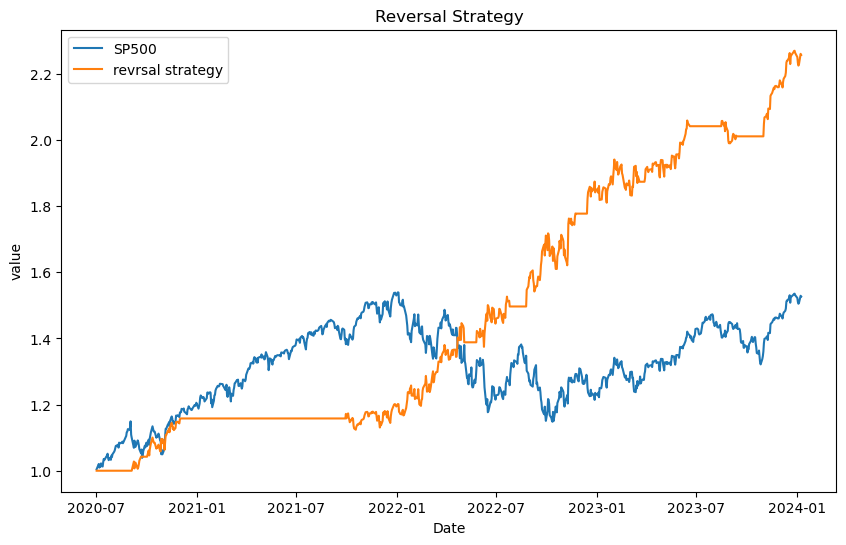

In [64]:
plt.figure(figsize=(10, 6))
plt.plot(strategy_result['SP500'], label='SP500')
plt.plot(strategy_result.loc[:,'performance'], label='revrsal strategy')
plt.legend()
plt.title('Reversal Strategy')
plt.xlabel('Date')
plt.ylabel('value')

In [65]:
strategy1 = strategy_result.loc[:,'performance']
strategy1

Date
2020-07-01         NaN
2020-07-02    1.000000
2020-07-06    1.000000
2020-07-07    1.000000
2020-07-08    1.000000
                ...   
2024-01-03    2.232284
2024-01-04    2.224631
2024-01-05    2.228692
2024-01-08    2.260150
2024-01-09    2.256809
Name: performance, Length: 887, dtype: float64

In [66]:
strategy_result['performance'].dropna()

Date
2020-07-02    1.000000
2020-07-06    1.000000
2020-07-07    1.000000
2020-07-08    1.000000
2020-07-09    1.000000
                ...   
2024-01-03    2.232284
2024-01-04    2.224631
2024-01-05    2.228692
2024-01-08    2.260150
2024-01-09    2.256809
Name: performance, Length: 886, dtype: float64

In [67]:
def calculate_metrics(cumret):
    '''
    calculate performance metrics from cumulative returns
    '''
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(252/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)
    
    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)
    
    return total_return, apr, sharpe, maxDD, maxDDD

In [68]:
metrics = pd.DataFrame(columns=['Total return', 'APR', 'Sharpe', 'MaxDD', 'MaxDDD'])
metrics.loc['strategy1'] = calculate_metrics(strategy_result['performance'].dropna())
metrics

,Total return,APR,Sharpe,MaxDD,MaxDDD
strategy1,1.256809,0.260499,1.729881,-0.062675,97.0


In [69]:
metrics.loc['SP500'] = calculate_metrics(strategy_result['SP500'].dropna())
metrics

,Total return,APR,Sharpe,MaxDD,MaxDDD
strategy1,1.256809,0.260499,1.729881,-0.062675,97.0
SP500,0.519644,0.126398,0.771077,-0.254251,506.0


without indicator

In [70]:
X = reversal_6m[['mu','skew','kurt','p50','pca']]
y = reversal_6m['OS_len_days']

X_train = X.loc['2007':'2020-06',:]
y_train = y.loc['2007':'2020-06']

X_test = X.loc['2020-07':,:]
y_test = y.loc['2020-07':]

In [71]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model, y_pred1 = model_training_and_evaluating(model, X_train, X_test, y_train, y_test,scaler=True)

Mean Squared Error: 3627.547300952415
Mean Absolute Error: 30.758611916477516
R2 Score: -0.038615077663104014


In [72]:
from sklearn.svm import SVR
model = SVR(kernel='rbf',C=100,epsilon=30)
model, y_pred2 = model_training_and_evaluating(model, X_train, X_test, y_train, y_test,scaler=True)

Mean Squared Error: 3498.9580941711924
Mean Absolute Error: 34.525555496195516
R2 Score: -0.001798276141962818


In [73]:
from xgboost import XGBRegressor
model = XGBRegressor(eval_metric='rmse',booster='gblinear')
model_training_and_evaluating(model, X_train, X_train, y_train, y_train, scaler=True)
model, y_pred3 = model_training_and_evaluating(model, X_train, X_test, y_train, y_test, scaler=True)

Mean Squared Error: 2844.673313407121
Mean Absolute Error: 31.366601058415004
R2 Score: 0.07034257458242354
Mean Squared Error: 3622.249436391994
Mean Absolute Error: 31.00850490161351
R2 Score: -0.03709822852086808


In [74]:
y_pred = (y_pred1+y_pred2+y_pred3)/3
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R2 Score: {r2}')

Mean Squared Error: 3545.796255554577
Mean Absolute Error: 31.646390612744657
R2 Score: -0.015208665197407711


In [75]:
trading_days = SP500_close.index
test_result = reversal_result.loc[X_test.index,['event','trend','DC_start','DC_end','OS_start','OS_end','DC_len','OS_len']]
test_result.loc[:,'OS_len_pred'] = y_pred
test_result.loc[:,'trading_start'] = test_result.loc[:,'OS_start']
test_result.loc[:,'trading_len'] = test_result.loc[:,'OS_len_pred'].round()
test_result.loc[:,'trading_len'] = np.minimum(test_result.loc[:,'trading_len'],test_result['OS_len'].dt.days+test_result['DC_len'].dt.days.shift(-1)).fillna(test_result.loc[:,'trading_len'])
test_result.loc[:,'trading_end'] = test_result.loc[:,'trading_start'] + pd.to_timedelta(test_result.loc[:,'trading_len'], unit='D')
test_result = pd.merge_asof(test_result, SP500_close, left_on='trading_start', right_index=True).dropna()
test_result = pd.merge_asof(test_result, SP500_close, left_on='trading_end', right_index=True).dropna()
test_result

,event,trend,DC_start,DC_end,OS_start,OS_end,DC_len,OS_len,OS_len_pred,trading_start,trading_len,trading_end,Close_x,Close_y
Date,,,,,,,,,,,,,,
2020-09-02,127,0,2020-09-02,2020-09-04,2020-09-04,2020-09-23,2 days,15 days,31.484516,2020-09-04,24.0,2020-09-28,3426.959961,3351.600098
2020-09-23,128,1,2020-09-23,2020-10-02,2020-10-02,2020-10-12,9 days,7 days,29.650933,2020-10-02,22.0,2020-10-24,3348.419922,3465.389893
2020-10-12,129,0,2020-10-12,2020-10-27,2020-10-27,2020-10-30,15 days,2 days,28.199004,2020-10-27,6.0,2020-11-02,3390.679932,3310.239990
2020-10-30,130,1,2020-10-30,2020-11-03,2020-11-03,2021-09-02,4 days,302 days,23.942446,2020-11-03,24.0,2020-11-27,3369.159912,3638.350098
2021-09-02,131,0,2021-09-02,2021-09-29,2021-09-29,2021-10-04,27 days,4 days,38.195198,2021-09-29,18.0,2021-10-17,4359.459961,4471.370117
2021-10-04,132,1,2021-10-04,2021-10-18,2021-10-18,2022-01-03,14 days,76 days,38.060775,2021-10-18,38.0,2021-11-25,4486.459961,4701.459961
2022-01-03,133,0,2022-01-03,2022-01-14,2022-01-14,2022-01-27,11 days,9 days,39.515794,2022-01-14,13.0,2022-01-27,4662.850098,4326.509766
2022-01-27,134,1,2022-01-27,2022-01-31,2022-01-31,2022-02-02,4 days,1 days,29.731876,2022-01-31,15.0,2022-02-15,4515.549805,4471.069824
2022-02-02,135,0,2022-02-02,2022-02-16,2022-02-16,2022-03-08,14 days,19 days,37.503024,2022-02-16,27.0,2022-03-15,4475.009766,4262.450195


In [76]:
strategy_result = pd.DataFrame(SP500_close).loc['2020-07':,:]
strategy_result.loc[:,'position'] = 0
for i in range(len(test_result)):
    trend = test_result.loc[test_result.index[i],'trend']
    trading_start = test_result.loc[test_result.index[i],'trading_start']
    trading_end = test_result.loc[test_result.index[i],'trading_end']
    if trend > 0:
        strategy_result.loc[trading_start:trading_end,'position'] = 1
    else:
        strategy_result.loc[trading_start:trading_end,'position'] = -1

strategy_result.loc[:,'daily_return'] = strategy_result.loc[:,'Close'].pct_change()
strategy_result.loc[:,'SP500'] = (1 + strategy_result.loc[:,'daily_return']).cumprod()
strategy_result.loc[:,'performance'] = (1 + strategy_result.loc[:,'position'].shift(1)*strategy_result.loc[:,'daily_return']).cumprod()

strategy_result.loc['2022-08-16':'2022-08-25',:]

,Close,position,daily_return,SP500,performance
Date,,,,,
2022-08-16,4305.200195,0,0.001876,1.381705,1.4568
2022-08-17,4274.040039,0,-0.007238,1.371705,1.4568
2022-08-18,4283.740234,0,0.002270,1.374818,1.4568
2022-08-19,4228.479980,0,-0.012900,1.357083,1.4568
2022-08-22,4137.990234,0,-0.021400,1.328041,1.4568
2022-08-23,4128.729980,0,-0.002238,1.325069,1.4568
2022-08-24,4140.770020,0,0.002916,1.328933,1.4568
2022-08-25,4199.120117,-1,0.014092,1.347660,1.4568


In [77]:
strategy_result

,Close,position,daily_return,SP500,performance
Date,,,,,
2020-07-01,3115.860107,0,NaN,NaN,NaN
2020-07-02,3130.010010,0,0.004541,1.004541,1.000000
2020-07-06,3179.719971,0,0.015882,1.020495,1.000000
2020-07-07,3145.320068,0,-0.010819,1.009455,1.000000
2020-07-08,3169.939941,0,0.007827,1.017356,1.000000
...,...,...,...,...,...
2024-01-03,4704.810059,0,-0.008016,1.509955,2.050072
2024-01-04,4688.680176,0,-0.003428,1.504779,2.050072
2024-01-05,4697.240234,0,0.001826,1.507526,2.050072


Text(0, 0.5, 'value')

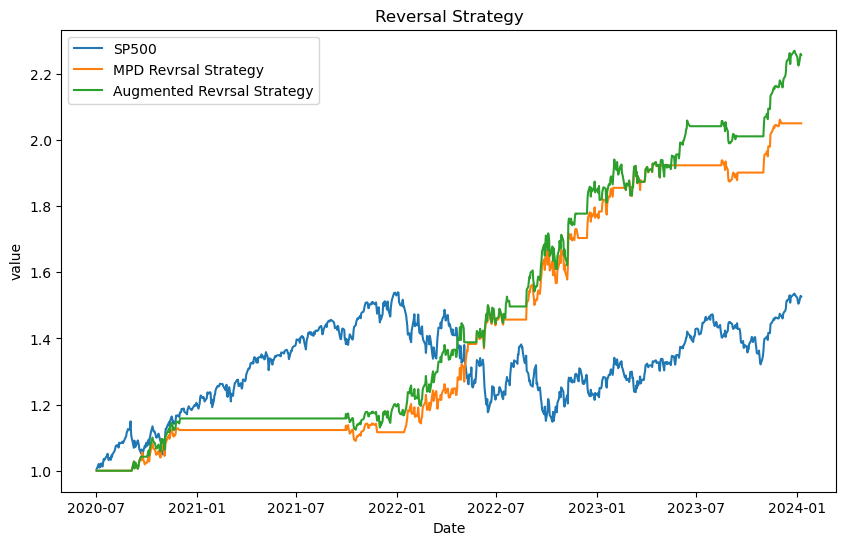

In [78]:
plt.figure(figsize=(10, 6))
plt.plot(strategy_result['SP500'], label='SP500')
plt.plot(strategy_result.loc[:,'performance'], label='MPD Revrsal Strategy')
plt.plot(strategy1, label='Augmented Revrsal Strategy')
plt.legend()
plt.title('Reversal Strategy')
plt.xlabel('Date')
plt.ylabel('value')

In [79]:
metrics.loc['strategy2'] = calculate_metrics(strategy_result['performance'].dropna())
metrics

,Total return,APR,Sharpe,MaxDD,MaxDDD
strategy1,1.256809,0.260499,1.729881,-0.062675,97.0
SP500,0.519644,0.126398,0.771077,-0.254251,506.0
strategy2,1.050072,0.226520,1.581363,-0.062675,210.0
